# Loading and Accessing SnowModel Output

Snow cover data for the Sunlight Under Sea Ice project are generated by SnowModel-LG [(Liston et al)]().  This model output includes snow depth and density, which can be downloaded from [Here](ftp://ftp.cira.colostate.edu/ftp/Liston/SnowModel_LG_1980-2018/Data/).  Fields are in the NSIDC North Polar Stereographic projection on the X grid.

Output from SnowModel-LG are stored in [GrADS](http://cola.gmu.edu/grads/grads.php) format.  GrADS is a complete analysis system.  All we want here is to read the files, and then perform analysis using the GeoScientific Python ecosystem. So I have written a simple GrADS reader that loads data into an `xarray.DataArray`.

GrADS data requires two files: a flat binary file (often with a `.gdat` extension) and a control file (`.ctl`).  The control file contains information about the dimensions and coordinates of the `.gdat` file, as well as information about the variables contained within that file.  `read_grads` expects `.ctl` and `.gdat` files to have the same basename and be in the same directory.  If they do not, the `.ctl` needs to be passed to `read_grads` as a keyword argument.

As a first step, we import python modules.

In [1]:
import os
import sys

sys.path.append("../sunderseaice")  # Add `sunlight` to $PYTHONPATH

import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import xarray as xr

from readers.snowmodel import read as read_snowmodel

Set the path to the data.  As an example, I'm reading the snow depth fields.

In [2]:
DATAPATH = os.path.join(os.path.sep, "home", "apbarret", "Data", "Snow_on_seaice", "SnowModelOutput")
datafile = os.path.join(DATAPATH, "MERRA2", "snod.gdat")
ctlfile = os.path.join(DATAPATH, "MERRA2", "SM_snod_merra2_01Aug1980-31Jul2018.ctl")
#datafile = os.path.join(DATAPATH, "ERA5", snod.gdat")
#ctlfile = os.path.join(DATAPATH, "ERA5", SM_snod_era5_01Aug1980-31Jul2018.ctl")

Load data into an xarray object.  These are large files, so you may run into some memory issues.  `read_snowmodel` returns a dask DataArray but I need to improve this to help with these out-of-memory conditions.

In [3]:
snowDepth = read_snowmodel(datafile, ctlfile)
snowDepth

,Array,Chunk
Bytes,7.23 GB,52.13 MB
Shape,"(13879, 361, 361)","(100, 361, 361)"
Count,418 Tasks,139 Chunks
Type,float32,numpy.ndarray


`snowDepth` is an `xarray.DataArray` wit.  Variables and coordinates do not have attributes.  Adding attributes is on the TBD list.  The x and y coordinates are also just row and column indices, not projected coordinates.

`xarray` has a number of methods to select individual cells or slices of cells.  More details can be found [here](http://xarray.pydata.org/en/stable/indexing.html).  I'll provide a few examples here.

The simplest approach is to access values by coordinate indices, where indices for `time`, `x` and `y` are 0 to 13878, 0 to 360 and 0 to 360 respectively.

In [4]:
snowDepth[0, 180, 180].values

array(0.00014652, dtype=float32)

This returns snow depth in meters for the cell with coordinates `(1980-08-01, -0.05, 0.05)`.  Note xarray indices are _zero-indexed_ but the array coordinates start at 1.

The above method is is a quick way to access data but is not the best way.  `xarray.DataArray` has `.loc`, `.sel` and `.isel` methods.  These are the preferred methods.  The `.loc` method allows coordinate values to be used but the coordinates need to be exact.

In [5]:
snowDepth.y[180].values, snowDepth.x[180].values

(array(0.05), array(0.05))

snowDepth.loc["1980-08-01", 0.05, -0.05]

`sel` uses named coordinates, which is easier to read.  However, this can cause problems if the coordinate values are not exact.  Add the method `nearest` tells `sel` to select the gridcell using the nearest-neighbour criterior.  `bilinear` can also be used.  Delete `method='nearest'` to see what happens if this is not specified (This may not fail once I round the x and y coordinates to 2 decimal places).

In [6]:
snowDepth.sel(time="1980-08-01", x=-0.05, y=0.05, method='nearest')

<xarray.DataArray ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1980-08-01
    x        float64 0.05
    y        float64 0.05
    z        float64 1.0

In [7]:
snowDepth.sel(x=-0.05, time="1980-08-01", y=0.05, method='nearest')

<xarray.DataArray ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1980-08-01
    x        float64 0.05
    y        float64 0.05
    z        float64 1.0

Also works.

In [8]:
snowDepth.isel(time=0)

<xarray.DataArray (x: 361, y: 361)>
dask.array<getitem, shape=(361, 361), dtype=float32, chunksize=(361, 361), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1980-08-01
  * x        (x) float64 4.512e+06 4.487e+06 4.462e+06 ... -4.487e+06 -4.512e+06
  * y        (y) float64 4.512e+06 4.487e+06 4.462e+06 ... -4.487e+06 -4.512e+06
    z        float64 1.0

`.sel` also allows selections along the time dimension by year and month, as well as by slices.

To access all data for a the year 2000

In [9]:
snowDepth.sel(time="2000")

<xarray.DataArray (time: 366, x: 361, y: 361)>
dask.array<getitem, shape=(366, 361, 361), dtype=float32, chunksize=(100, 361, 361), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2000-12-31
  * x        (x) float64 4.512e+06 4.487e+06 4.462e+06 ... -4.487e+06 -4.512e+06
  * y        (y) float64 4.512e+06 4.487e+06 4.462e+06 ... -4.487e+06 -4.512e+06
    z        float64 1.0

To get all data for April 2000 you can pass 2000-04 to sel.  Note that the "-" is important, 200004 will not work.

In [10]:
snowDepth.sel(time="2000-04")

<xarray.DataArray (time: 30, x: 361, y: 361)>
dask.array<getitem, shape=(30, 361, 361), dtype=float32, chunksize=(17, 361, 361), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-04-01 2000-04-02 ... 2000-04-30
  * x        (x) float64 4.512e+06 4.487e+06 4.462e+06 ... -4.487e+06 -4.512e+06
  * y        (y) float64 4.512e+06 4.487e+06 4.462e+06 ... -4.487e+06 -4.512e+06
    z        float64 1.0

Use `slice()` to get a time slice of data for a given period.  To get the accumulation and melt season for the 1999-08-01 to 2000-07-31 period use

In [11]:
snowDepth.sel(time=slice("19990801", "20000731"))

<xarray.DataArray (time: 366, x: 361, y: 361)>
dask.array<getitem, shape=(366, 361, 361), dtype=float32, chunksize=(100, 361, 361), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1999-08-01 1999-08-02 ... 2000-07-31
  * x        (x) float64 4.512e+06 4.487e+06 4.462e+06 ... -4.487e+06 -4.512e+06
  * y        (y) float64 4.512e+06 4.487e+06 4.462e+06 ... -4.487e+06 -4.512e+06
    z        float64 1.0

Likewise to get slices of x and y coordinates

In [12]:
snowDepth.sel(x=slice(-100000,100000), y=slice(-100000,100000))

<xarray.DataArray (time: 13879, x: 0, y: 0)>
dask.array<getitem, shape=(13879, 0, 0), dtype=float32, chunksize=(100, 0, 0), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-08-01 1980-08-02 ... 2018-07-31
  * x        (x) float64 
  * y        (y) float64 
    z        float64 1.0

Values can be aggregated as means or standard deviations.  Generating a time series of mean snow depth for the region selected above for 1999-08-01 to 2000-07-31 is done as follows

In [13]:
ts = snowDepth.sel(time=slice("19990801", "20000731"), x=slice(-100000,100000), y=slice(-100000,100000)).mean(dim=['x','y'])
ts

<xarray.DataArray (time: 366)>
dask.array<mean_agg-aggregate, shape=(366,), dtype=float32, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1999-08-01 1999-08-02 ... 2000-07-31
    z        float64 1.0

/home/apbarret/anaconda3/envs/sunlight_under_seaice/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


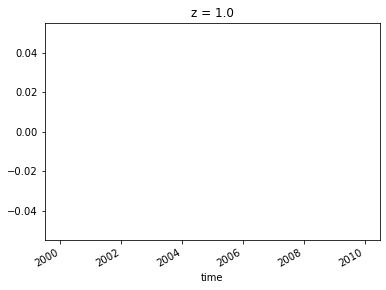

In [14]:
ts.plot()

A field can be plotted

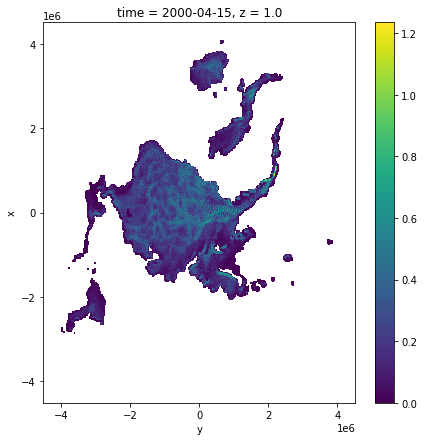

In [15]:
fig, ax = plt.subplots(figsize=(7,7))
snowDepth.sel(time='2000-04-15').plot(ax=ax)

In [16]:
SphericalEarth = ccrs.Globe(semimajor_axis=6371228., semiminor_axis=6371228.)
NSIDC_EASE = ccrs.LambertAzimuthalEqualArea(central_latitude=90., central_longitude=0., globe=SphericalEarth)

extent = [-4524683.8, 4524683.8, -4524683.8, 4524683.8]

Need to figure out geotransform and how xarray indexes arrays

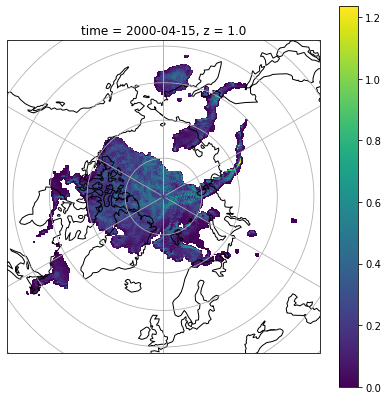

In [17]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection=NSIDC_EASE)
ax.set_extent(extent, NSIDC_EASE)
ax.coastlines()
ax.gridlines()
snowDepth.sel(time='2000-04-15').plot(ax=ax)

In [ ]:
ds = snowDepth.to_dataset(name='snow_depth')
ds = ds.drop('z')

## Generate 2-dimensional latitude and longitude grids

In [ ]:
x2d, y2d = np.meshgrid(ds.x, ds.y)
geo_proj = ccrs.PlateCarree(globe=NSIDC_EASE.globe)
geo_coords = geo_proj.transform_points(NSIDC_EASE, x2d, y2d)
lon = geo_coords[:, :, 0]
lat = geo_coords[:, :, 1]

ds['lon'] = xr.DataArray(lon, coords=[ds.x, ds.y], dims=['x', 'y'])
ds['lat'] = xr.DataArray(lat, coords=[ds.x, ds.y], dims=['x', 'y'])

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection=NSIDC_EASE)
ax.set_extent(extent, NSIDC_EASE)
ax.coastlines()
ax.gridlines()
ax.pcolormesh(lon, lat, ds.snow_depth.sel(time='2000-04-15'), transform=geo_proj)

## Create global and varable attributes

In [ ]:
ds.attrs = {
    'title': 'snow depth on sea ice',
    'institution': 'CIRA, Colorado State University',
    'creator': 'Glen.Liston@colostate.edu',
    'source': 'SnowModel-LG',
    'projection': 'NSIDC EASE',
    'proj4_string': NSIDC_EASE.proj4_init,
    'crs': 'EPSG:3408',
    'reference': ('Liston, G. E., Itkin, P., Stroeve, J., Tschudi, M., Stewart, J. S., & Pedersen, S. H., et al. (2020). '
                  'A Lagrangian snow‐evolution system for sea‐ice applications (SnowModel‐LG): Part I—Model description. '
                  'Journal of Geophysical Research: Oceans, 125, e2019JC015913. https://doi.org/10.1029/2019JC015913')
}

ds.snow_depth.attrs = {
    'long_name': 'snow depth',
    'standard_name': 'surface_snow_thickness_where_sea_ice',
    'units': 'm'
}

ds.lon.attrs = {
    'long_name': 'longitude',
    'units': 'degrees_east'
}

ds.lat.attrs = {
    'long_name': 'latitude',
    'units': 'degrees_north'
}

ds.time.attrs = {
    'long_name': 'time',
}

ds.x.attrs = {
    'long_name': 'x-coordinate of projection',
    'standard_name': 'projection_x_coordinate',
    'units': 'm',    
}

ds.y.attrs = {
    'long_name': 'y-coordinate of projection',
    'standard_name': 'projection_y_coordinate',
    'units': 'm',    
}



In [ ]:
ds

In [ ]:
ds.transpose("time", "x", "y")

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection=NSIDC_EASE)
ax.set_extent(extent, NSIDC_EASE)
ax.coastlines()
ax.gridlines()
ds.snow_depth.sel(time='2000-04-15').plot(ax=ax)

In [ ]:
encoding = {
    'snow_depth': {
        'zlib': True,
        'complevel': 9,
        '_FillValue': -9999.99
    },
}
ds.load()

In [ ]:
ds.to_netcdf('snow_depth_test.nc', encoding=encoding)